In [93]:
import pandas as pd
import geopandas as gpd
import tensorflow as tf
# import teller as tr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
import missingno as msno
# import pyarrow as pa
# import pyarrow.parquet as pq
import numpy as np



In [94]:
# !pip install tensorflow
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno

In [95]:

path = './edit1_jedna_kolumna_in.geojson'
df_p = gpd.read_file(path)


<Axes: >

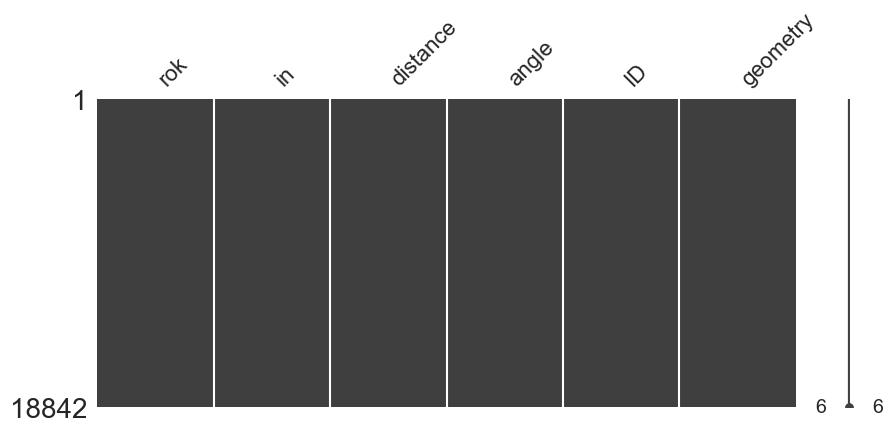

In [96]:
msno.matrix(df_p, figsize=(10,4)) # test pustych wierszy
# df_p =df_p.fillna(0) # wypełnianie Nan zerami


In [97]:
df_p.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rok,18842.0,2016.831228,3.893406,2011.000000,2013.00000,2019.000000,2020.000000,2022.000000
distance,18842.0,155.718688,42.799975,78.225285,126.23215,146.396017,180.949599,299.853974
angle,18842.0,186.149193,90.657529,28.200000,107.62500,186.150000,264.675000,343.300000
ID,18842.0,9421.500000,5439.361222,1.000000,4711.25000,9421.500000,14131.750000,18842.000000


In [98]:
df_p.head()

,rok,in,distance,angle,ID,geometry
0,2011,True,299.853974,28.2,1,"LINESTRING (7527541.11000 5863838.87000, 75276..."
1,2011,True,299.527086,28.3,2,"LINESTRING (7527541.11000 5863838.87000, 75276..."
2,2011,True,299.201822,28.4,3,"LINESTRING (7527541.11000 5863838.87000, 75276..."
3,2011,True,298.878172,28.5,4,"LINESTRING (7527541.11000 5863838.87000, 75276..."
4,2011,True,298.556130,28.6,5,"LINESTRING (7527541.11000 5863838.87000, 75276..."


In [99]:
df_p.shape


(18842, 6)

In [100]:
#normalizacja i podzial na dane wejsciowe i wyjsciowe
X = df_p[["rok", "in", "distance", "angle"]]
X = MinMaxScaler().fit_transform(X)
y = df_p["distance"]
X.shape, y.shape

((18842, 4), (18842,))

In [101]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     # random_state=42,
                                                     test_size=.4)

In [102]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11305, 4), (7537, 4), (11305,), (7537,))

# MODEL

In [103]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate,Dropout,CategoryEncoding, Embedding, Flatten,Conv2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.random import set_seed #ustawiam ziarno pseudolosowości
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime as dt
import os

In [104]:
N_TRAIN = int(1e4)
BATCH_SIZE = 12
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

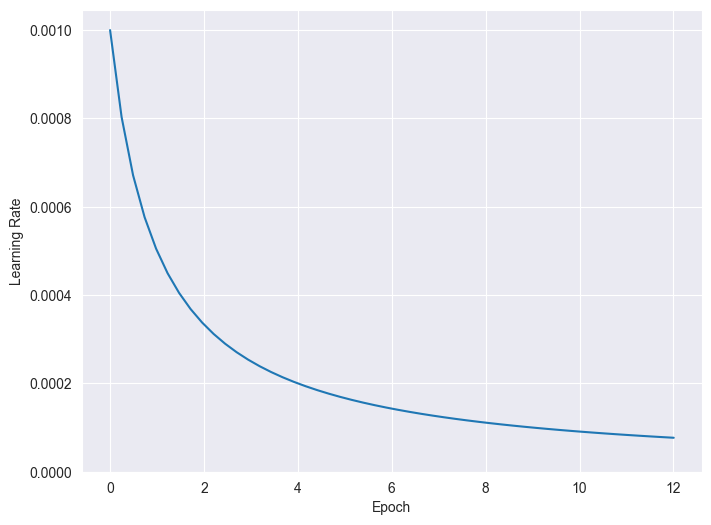

In [105]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [106]:
from keras import regularizers


def create_ANN():
    set_seed(0)
    model = Sequential()
    model.add(
        Dense(2, activation='relu',
              kernel_regularizer=regularizers.l2(0.001), #opcja
              kernel_initializer='he_uniform')
    )
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(8, activation='relu'))
    # model.add(Dense(8, activation='relu'))
    model.add(
        Dense(1, activation='relu',
              kernel_regularizer=regularizers.l2(0.001))# opcja
    )

    model.compile(
        loss='mse',
        optimizer=get_optimizer(),
        metrics=['mae','mse'])

    return model

In [107]:
_filepath = 'checkpoint/ann-{epoch:02d}-{loss:.3f}.h5' # for filepath
checkpoint = ModelCheckpoint(monitor='loss', filepath='checkpoint/_best-ann.h5', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='loss', patience=3, min_delta=0.01, verbose=1)
tb = TensorBoard(log_dir='logs/'+dt.now().strftime("%Y%m%d-%H%M%S")) # logi tensor board

In [108]:
model = create_ANN()

result = model.fit(
    X_train, y_train,
    epochs=400,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    validation_split=.3,
    callbacks=[checkpoint,tb],
    verbose=0,
)


Epoch 1: loss improved from inf to 20139.96094, saving model to checkpoint\_best-ann.h5


C:\Users\patry\Desktop\ai_river_project\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: loss improved from 20139.96094 to 7490.02832, saving model to checkpoint\_best-ann.h5

Epoch 3: loss improved from 7490.02832 to 6675.90283, saving model to checkpoint\_best-ann.h5

Epoch 4: loss improved from 6675.90283 to 6012.78271, saving model to checkpoint\_best-ann.h5

Epoch 5: loss improved from 6012.78271 to 5259.12256, saving model to checkpoint\_best-ann.h5

Epoch 6: loss improved from 5259.12256 to 4782.33740, saving model to checkpoint\_best-ann.h5

Epoch 7: loss improved from 4782.33740 to 4291.86670, saving model to checkpoint\_best-ann.h5

Epoch 8: loss improved from 4291.86670 to 3864.55151, saving model to checkpoint\_best-ann.h5

Epoch 9: loss improved from 3864.55151 to 3554.19653, saving model to checkpoint\_best-ann.h5

Epoch 10: loss improved from 3554.19653 to 3283.26318, saving model to checkpoint\_best-ann.h5

Epoch 11: loss improved from 3283.26318 to 2940.57666, saving model to checkpoint\_best-ann.h5

Epoch 12: loss improved from 2940.57666 to 267

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2)                 10        
                                                                 
 dropout_5 (Dropout)         (None, 2)                 0         
                                                                 
 dense_21 (Dense)            (None, 6)                 18        
                                                                 
 dense_22 (Dense)            (None, 8)                 56        
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 93 (372.00 Byte)
Trainable params: 93 (372.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


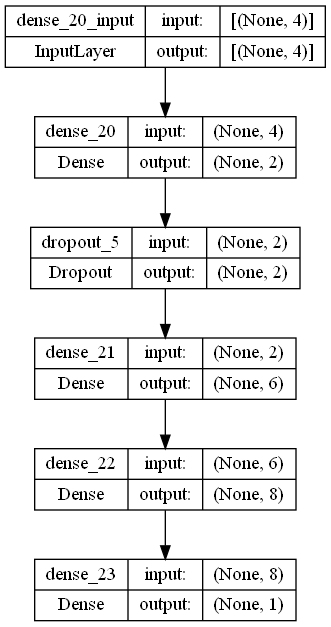

In [109]:
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [110]:
# evaluate the keras model
loss,  mae , mse = model.evaluate(X_test, y_test)
print(f'loss:{loss}, \nmse: {mse}')

236/236 [==============================] - 1s 2ms/step - loss: 499.1820 - mae: 16.8592 - mse: 499.1551
loss:499.1820068359375, 
mse: 499.1551208496094


Text(0.5, 0, 'Epoka')

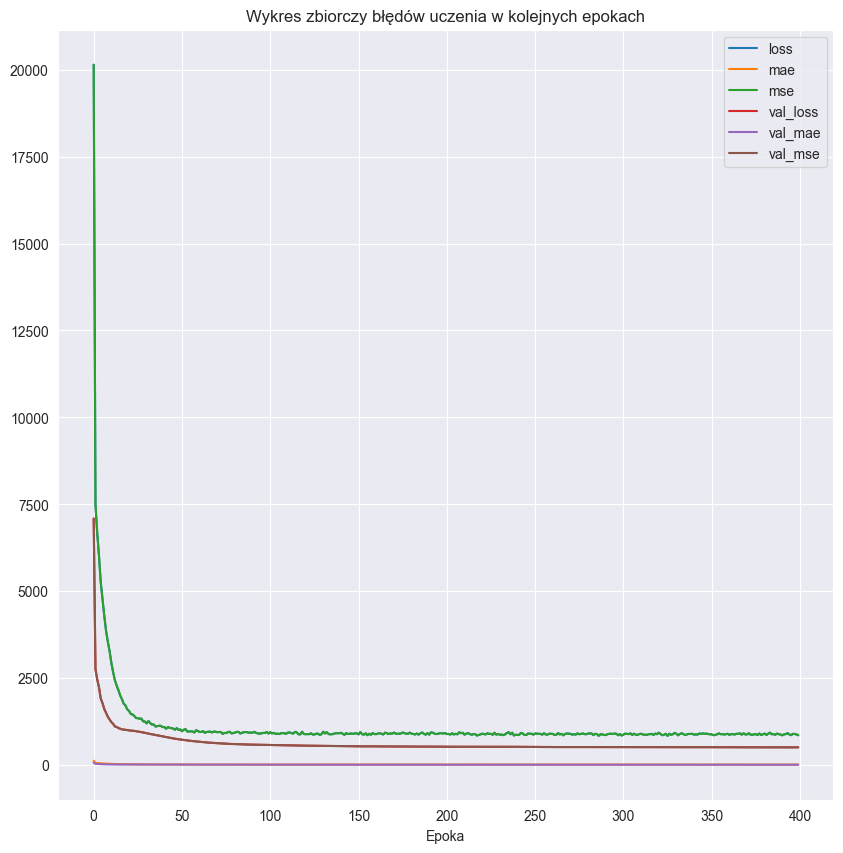

In [111]:
df_results = pd.DataFrame(result.history)
df_results.plot(figsize=(10,10))
plt.title('Wykres zbiorczy błędów uczenia w kolejnych epokach')
plt.xlabel('Epoka')

In [112]:
df_results

,loss,mae,mse,val_loss,val_mae,val_mse
0,20139.960938,132.907852,20139.949219,7094.577148,76.164871,7094.563477
1,7490.028320,69.032494,7490.011719,2763.670654,41.203888,2763.651123
2,6675.902832,64.134789,6675.880859,2468.225586,38.291916,2468.207031
3,6012.782715,60.757729,6012.758789,2239.038574,35.811237,2239.017578
4,5259.122559,56.268959,5259.098145,1918.371338,32.260723,1918.350952
...,...,...,...,...,...,...
395,867.001343,20.728357,866.974304,516.796387,17.228678,516.769165
396,905.179810,20.945198,905.152466,516.695679,17.227045,516.668701
397,901.201050,20.911072,901.174255,516.339966,17.218681,516.312988
398,886.789917,20.860327,886.763428,516.739929,17.228790,516.712769


In [113]:
y_predicted = model.predict(X_test)

236/236 [==============================] - 1s 2ms/step


In [114]:
df__a = pd.DataFrame(y_test)
df__a['y_predicted']=y_predicted
df__a['diff']=df__a.y_predicted-df__a.distance
df__a['abs_diff'] = abs(df__a['diff'])
df__a['diff_pow']=df__a['diff']*df__a['diff']
df__a.tail()

,distance,y_predicted,diff,abs_diff,diff_pow
1550,184.680893,171.048935,-13.631958,13.631958,185.830289
11680,123.181702,138.962158,15.780457,15.780457,249.022809
4676,186.524236,171.675461,-14.848775,14.848775,220.486124
8151,171.201077,160.414536,-10.786541,10.786541,116.349468
5369,122.484562,138.962158,16.477596,16.477596,271.511168


In [115]:
import math
mean_ref = df__a['distance'].describe()[1]
bias = df__a['diff'].describe()[1]
mae =df__a['abs_diff'].describe()[1]
RMSE = math.sqrt(df__a['diff_pow'].sum()/df__a.shape[0])
print(
    f'mean_ref: {mean_ref},'
    f'\nbias: {bias}, \nbias_%: {bias/mean_ref*100}, '
    f'\nmae: {mae}, \nmae_%: {mae/mean_ref*100}, '
    f'\nRMSE: {RMSE} \nRMSE %: {RMSE/mean_ref*100}'
)

mean_ref: 155.85899895145323,
bias: -0.05159950891791639, 
bias_%: -0.03310653171459708, 
mae: 16.85925345195004, 
mae_%: 10.816990719413859, 
RMSE: 22.341781072609667 
RMSE %: 14.334610913014178


C:\Users\patry\AppData\Local\Temp\ipykernel_14188\758387956.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_ref = df__a['distance'].describe()[1]
C:\Users\patry\AppData\Local\Temp\ipykernel_14188\758387956.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bias = df__a['diff'].describe()[1]
C:\Users\patry\AppData\Local\Temp\ipykernel_14188\758387956.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mae =df__a['abs_diff']

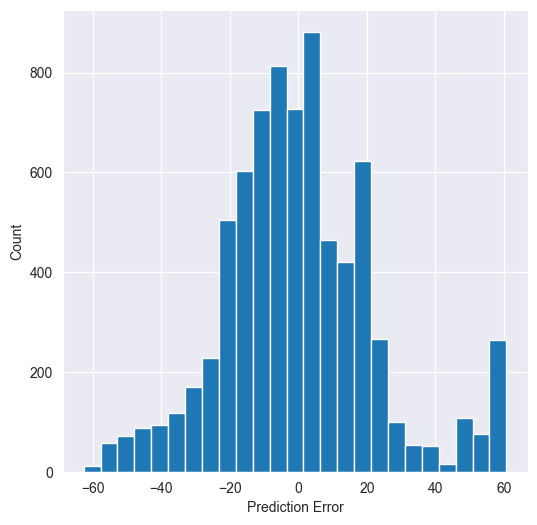

In [116]:
# rozkład błedów
error = df__a.y_predicted-df__a.distance
plt.figure(figsize = (6,6))
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

<Figure size 800x800 with 0 Axes>

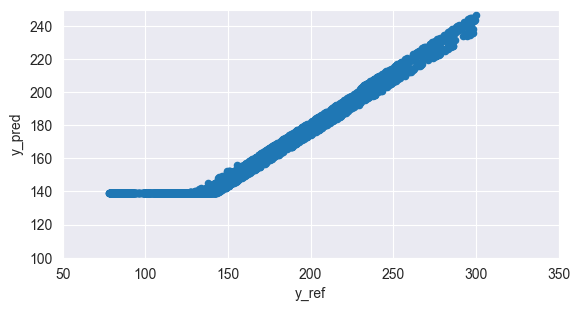

In [117]:
plt.figure(figsize = (8,8))
df__a.plot.scatter(y='y_predicted', x='distance')
plt.plot(range(5), color='orange')
plt.xlim(50, 350)
plt.ylim(100, 250)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('y_ref')
plt.ylabel('y_pred')
plt.draw()

In [118]:
# print(y_predicted)

In [119]:

# df__a = pd.merge(df__a, df_p[['ID', 'angle']], left_index=True, right_index=True)
# print(df__a)


In [120]:
# df__a.to_csv(path_or_buf="./results.csv",index=False,quoting=3,sep=';')